In [149]:
import collections
import numpy as np
import matplotlib.pyplot as plt

Top parameters for count 1
[(0.0, 7, 0.2), (0.0, 7, 0.3), (0.0, 7, 0.4), (0.0, 11, 0.2), (0.0, 11, 0.3)]
Top parameters for count 5
[(0.306, 15, 0.4), (0.378, 15, 0.3), (0.3892, 11, 0.4), (0.46079999999999993, 11, 0.3), (0.4616, 15, 0.2)]
Top parameters for count 10
[(0.5426, 15, 0.4), (0.5962000000000001, 15, 0.3), (0.6496000000000001, 11, 0.4), (0.6892, 11, 0.3), (0.7031999999999999, 15, 0.2)]
Top parameters for count 15
[(0.6835999999999999, 15, 0.4), (0.7174666666666667, 15, 0.3), (0.7753333333333334, 11, 0.4), (0.798, 11, 0.3), (0.8018666666666668, 15, 0.2)]
Top parameters for count 20
[(0.7768999999999999, 15, 0.4), (0.797, 15, 0.3), (0.843, 15, 0.2), (0.8459000000000001, 11, 0.4), (0.8466000000000001, 11, 0.3)]
Top parameters for count 25
[(0.8328800000000001, 15, 0.4), (0.8444, 15, 0.3), (0.8842400000000001, 15, 0.2), (0.89168, 11, 0.3), (0.8968, 11, 0.4)]
Top parameters for count 30
[(0.8721333333333334, 15, 0.3), (0.8728666666666668, 15, 0.4), (0.8986666666666668, 15, 0.2), (

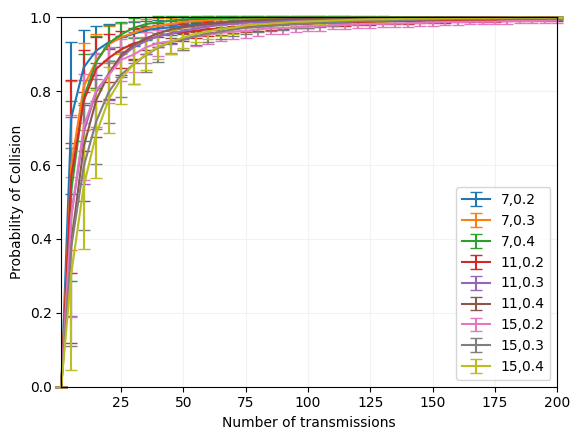

7 85.71428571428571
7 85.71428571428571
7 85.71428571428571
11 54.54545454545455
11 54.54545454545455
11 54.54545454545455
15 40.0
15 40.0
15 40.0


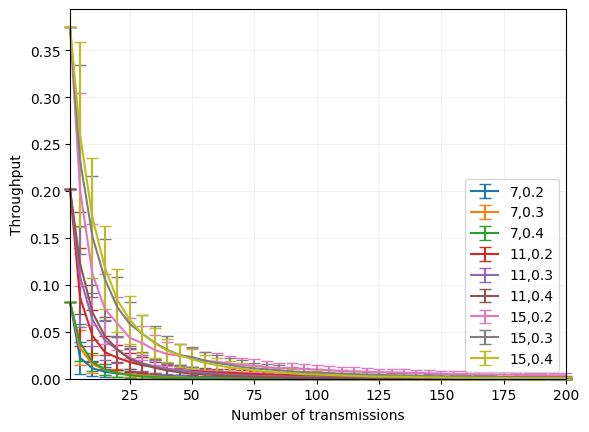

In [236]:
t_slot = 500 / 1000

###
### Below we have implemented the probabilistic model for collisions using a reverse-exponential distribution
### 

results = {}

possible_num_trans = [1] + list(range(5, 205, 5)) # This value represents the number of simultaneous transmissions, similar to number of nodes
# possible_slots = list(range(3, 31, 4))
possible_slots = [7, 11, 15]
# possible_alphas = [x / 10 for x in range(1, 7, 1)]
possible_alphas = [0.200, 0.300, 0.400]

n_iters = 500
for num_slots in possible_slots:
    for alpha in possible_alphas:
        results[(num_slots, alpha)] = {}
        
        for n_samples in possible_num_trans:
            p_collisions = []
            
            for _ in range(n_iters):
                t_max = num_slots * t_slot

                # Select samples from an exponential distribution
                mean = t_max * alpha
                samples = np.random.exponential(mean, n_samples)
                # print(samples)
                # print("Max before clamping", max(samples))

                # Since samples can be out of bounds i.e. greater than the last slot we need to clamp it
                samples = np.clip(samples, 0, t_max)
                # print("Max after clamping", max(samples))

                # plt.hist(samples, bins=num_slots)
                # plt.show()

                # We want a reverse-exponential distribution so that successful transmissions are first
                samples = t_max - samples
                # print(samples)

                # Clamp samples to the nearest bottom slot
                samples = t_slot * np.floor(samples / t_slot)
                # print(samples)
                # print(set(samples))

                # Pick slot number
                slots = samples / t_slot
                # print(slots)
                # print(set(slots))

                counts = list(collections.Counter(slots).values())
                # counts, _, _ = plt.hist(slots, bins=num_slots)
                # plt.show()
                # print(counts)

                # Compute probability of collision
                p_collision = 1 - (sum([count for count in counts if count == 1]) / n_samples)
                # print(p_collision)
                p_collisions.append(p_collision)

            results[(num_slots, alpha)][n_samples] = p_collisions
            
            
# print(results)

results_by_count = {}
for count in possible_num_trans:
    results_by_count[count] = []

for num_slots, alpha in results:
    for count in possible_num_trans:
        y = np.average(results[(num_slots, alpha)][count])
        results_by_count[count].append((y, num_slots, alpha))
        
for count in results_by_count:
    results_by_count[count].sort()
    print("Top parameters for count", count)
    print(results_by_count[count][:5])
    


for num_slots, alpha in results:
    x = list(results[(num_slots, alpha)].keys())
    ys = [results[(num_slots, alpha)][n_samples] for n_samples in x]
    y = [np.average(y) for y in ys]
    yerr = [np.std(y) for y in ys]

    plt.errorbar(x, y, yerr=yerr, label=f"{num_slots},{alpha}", capsize=4, clip_on=False)

plt.ylabel("Probability of Collision")
plt.xlabel("Number of transmissions")
plt.legend(loc='lower right', ncol=1)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0.0, 1.0)
plt.xlim(min(possible_num_trans), max(possible_num_trans))

plt.show()

duration = 5 * 60 # seconds

for num_slots, alpha in results:
    num_rounds = duration / (num_slots * t_slot)
    print(num_slots, num_rounds)
    
    x = list(results[(num_slots, alpha)].keys())
    ys = [(1 - np.array(results[(num_slots, alpha)][n_samples])) * num_slots / num_rounds for n_samples in x]
    y = [np.average(y) for y in ys]
    yerr = [np.std(y) for y in ys]

    plt.errorbar(x, y, yerr=yerr, label=f"{num_slots},{alpha}", capsize=4, clip_on=False)

plt.ylabel("Throughput")
plt.xlabel("Number of transmissions")
plt.legend(loc='lower right', ncol=1)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0.0)
plt.xlim(min(possible_num_trans), max(possible_num_trans))

plt.show()